# PALMER PENGUINS NOTEBOOK

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from graphviz import Source
from IPython.display import display,Markdown
# Dataset loaders
from palmerpenguins import load_penguins 

d:\Study\Co so tri tue nhan tao\CSTTNTPROJECT2\.venv\Lib\site-packages\palmerpenguins\penguins.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## 2. Load Dataset + Basic Preprocessing

In [2]:
penguins =load_penguins()
# Remove any rows where the 'species' value is missing (NaN)
penguins_cleaned = penguins.dropna(subset=['species']).copy()
# Separate the dataset into features (X) and target labels (y)
X = penguins_cleaned.drop(columns=['species'])
y = penguins_cleaned['species']
print("Shape after removing missing species:")
print("X shape:", X.shape)
print("y shape:", y.shape)

Shape after removing missing species:
X shape: (344, 7)
y shape: (344,)


## 3. Full Preprocessing with Imputer + OneHotEncoder

In [3]:
def preprocess_features(X):
    # Identify the names of categorical and numerical columns in the dataset
    categorical_columns = X.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_columns = X.select_dtypes(include=['number']).columns.tolist()
     # For numerical columns: replace missing values with the mean of each column
     # For categorical columns: one-hot encode and handle unknown categories
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(strategy='mean'), numerical_columns),
            ('cat', OneHotEncoder(handle_unknown='ignore',sparse_output=False), categorical_columns)
        ],
        remainder='passthrough'
    )
    X_processed = preprocessor.fit_transform(X)
    feature_names = numerical_columns.copy()
    if categorical_columns:
        cat_encoded_names= preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
        feature_names.extend(cat_encoded_names)
    return pd.DataFrame(X_processed, columns=feature_names)

## 4. Data Splitting


In [4]:
# Split data into train/test sets with stratified sampling to maintain class distribution
def split_dataset(X,y,test_size):
    return train_test_split(X,y,test_size=test_size,stratify=y,shuffle=True, random_state=42)

## 5. Train Decision Tree

In [5]:
# Create a decision tree classifier with entropy criterion
def train_decision_tree(X_train, y_train, max_depth=None):
    clf = DecisionTreeClassifier(criterion='entropy',max_depth=max_depth, random_state=42)
    clf.fit(X_train, y_train)
    return clf

## 6. Visualize Label Distribution

In [6]:
# Function to visualize the label distribution
def plot_distribution(y, title):
    y = pd.Series(y.ravel())  # Ensure 1D
    sns.countplot(x=y)
    plt.title(title)
    plt.xlabel("Species")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()

## 7. Visualize Decision Trees with Graphviz

In [7]:
# Export the trained decision tree to DOT format (Graphviz format)
def draw_decision_tree(tree_model, feature_names,class_names):
    dot_data = tree.export_graphviz(
        tree_model,
        out_file=None, 
        feature_names=feature_names,  
        class_names=class_names,  
        filled=True,
        rounded=True,  
        special_characters=True)  
    graph = Source(dot_data)
    display(graph)
    

## 8. Classification Report

In [8]:
def print_classification_report(y_test,y_pred,target_names):
    print(classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names))


## 9. Confusion Matrix

In [9]:
def plot_confusion_matrix(y_test, y_pred,target_names,labels,depth,test_size):
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    figure,axes = plt.subplots(figsize=(8, 8))
    display.plot(ax=axes, cmap=plt.cm.Blues, values_format='d')
    plt.title(f"Confusion Matrix (Depth={depth}, {100 - int(test_size * 100)}/{int(test_size * 100)} Split)")
    plt.grid(False)
    plt.show()

## 10. Max Depth - Accurary

In [10]:
# Print table of relationship between max_depth and accuracy
def print_max_depth_accuracy(max_depths, accuracies):
    df = pd.DataFrame([accuracies],columns=[str(v) if v is not None else 'None' for v in max_depths],index=['Accuracy'])
    df.columns.name = 'max_depth'
    print(df)

# Draw a chart of accuracy by max_depth
def max_depth_accuracy_chart(max_depths,accuracies):
    plot_x = [-1 if v is None else v for v in max_depths]
    labels_x =[str(v) if v is not None else 'None' for v in max_depths]
    plt.figure(figsize=(10, 6))
    plt.plot(plot_x,accuracies,'o-', color='blue')
    plt.title('Decision Tree Accuracy by Maximum Depth')
    plt.xlabel('Max Depth')
    plt.ylabel('Accuracy')
    plt.xticks(plot_x, labels_x)
    plt.grid(True)
    plt.show()


## 11. Main

0: Train/Test = 40/60


### Test Size: 0.6

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9000\2512977432.py:3: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y = pd.Series(y.ravel())  # Ensure 1D


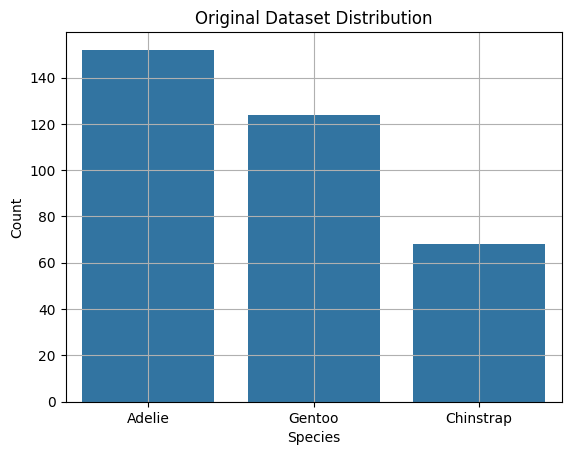

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9000\2512977432.py:3: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y = pd.Series(y.ravel())  # Ensure 1D


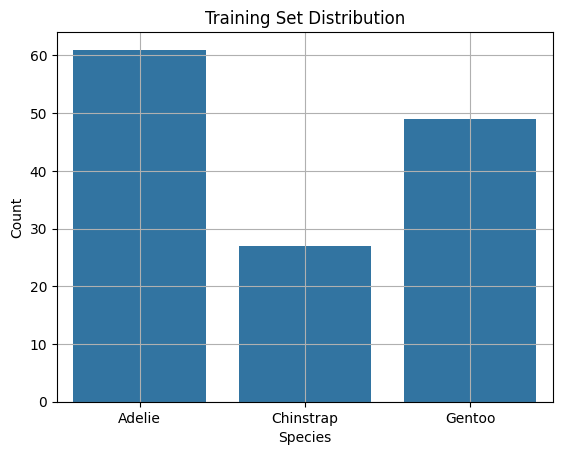

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9000\2512977432.py:3: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y = pd.Series(y.ravel())  # Ensure 1D


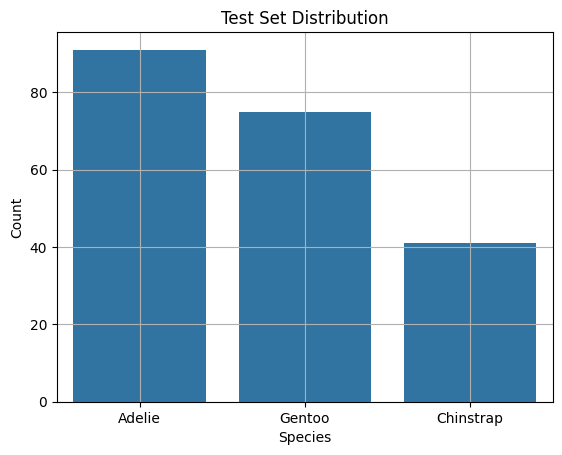

### Decision Tree Visualization

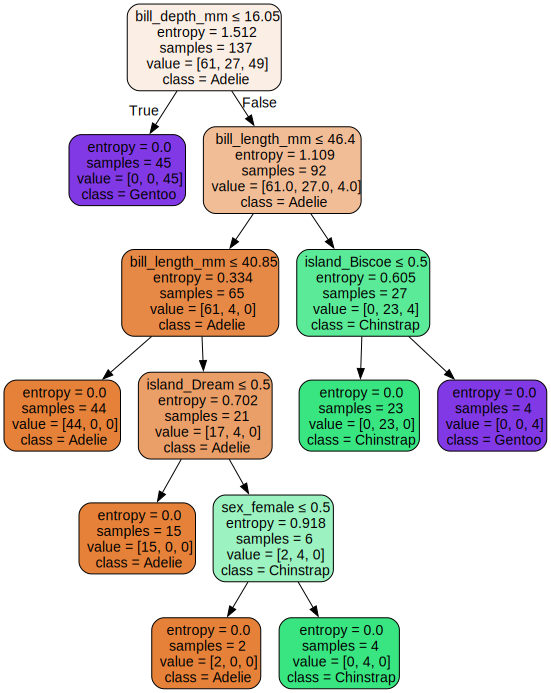

### Classification Report

              precision    recall  f1-score   support

      Adelie       0.97      0.96      0.96        91
   Chinstrap       0.98      1.00      0.99        41
      Gentoo       0.96      0.96      0.96        75

    accuracy                           0.97       207
   macro avg       0.97      0.97      0.97       207
weighted avg       0.97      0.97      0.97       207



### Confusion Matrix

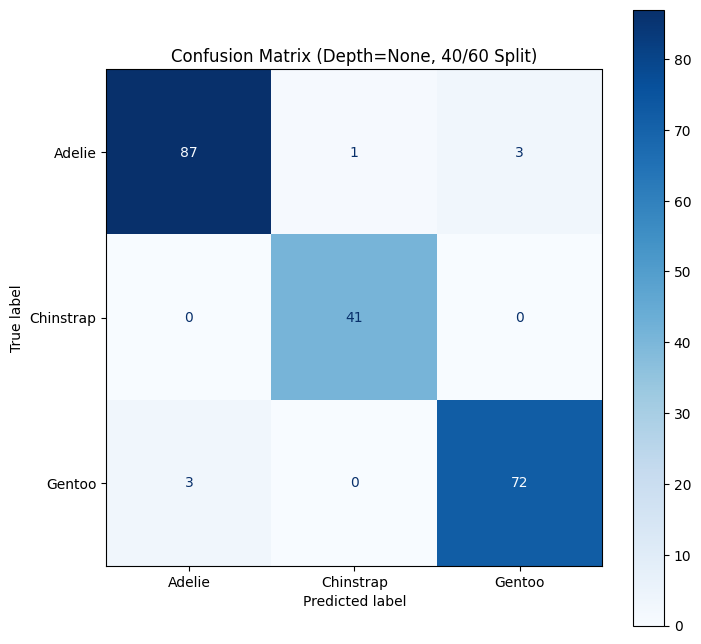

1: Train/Test = 60/40


### Test Size: 0.4

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9000\2512977432.py:3: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y = pd.Series(y.ravel())  # Ensure 1D


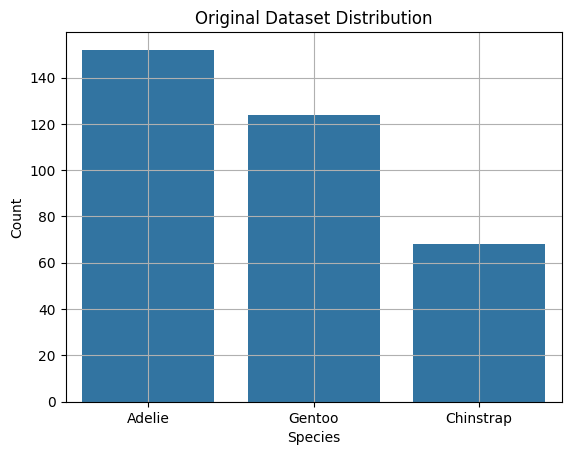

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9000\2512977432.py:3: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y = pd.Series(y.ravel())  # Ensure 1D


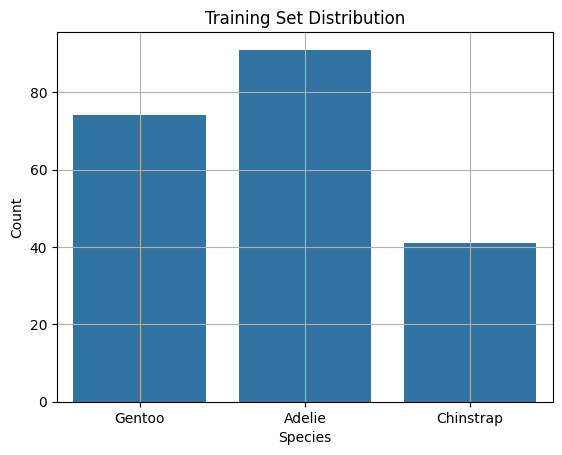

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9000\2512977432.py:3: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y = pd.Series(y.ravel())  # Ensure 1D


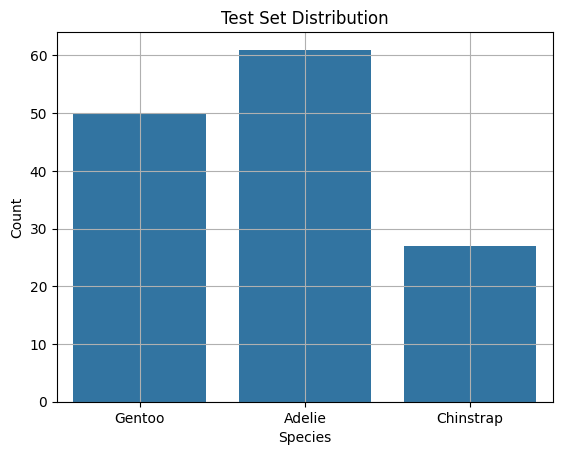

### Decision Tree Visualization

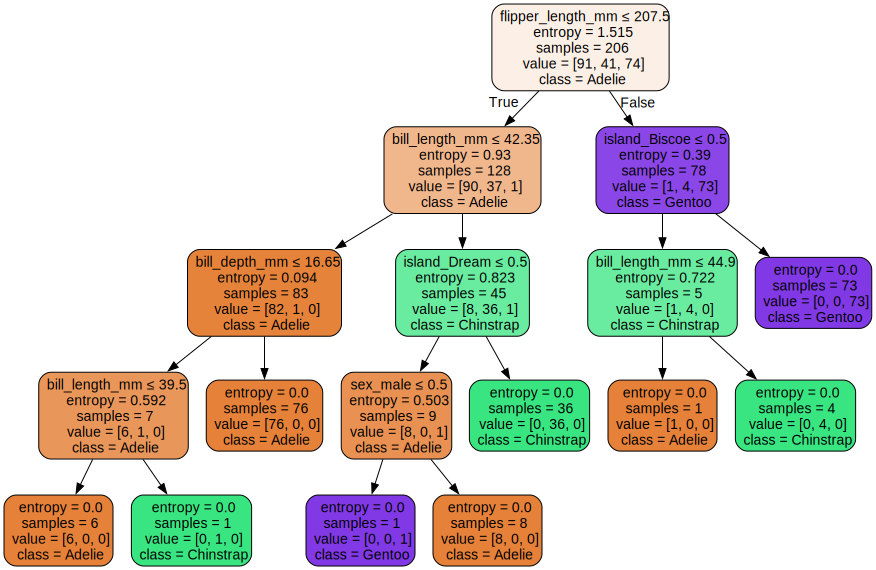

### Classification Report

              precision    recall  f1-score   support

      Adelie       1.00      0.95      0.97        61
   Chinstrap       0.93      1.00      0.96        27
      Gentoo       0.98      1.00      0.99        50

    accuracy                           0.98       138
   macro avg       0.97      0.98      0.98       138
weighted avg       0.98      0.98      0.98       138



### Confusion Matrix

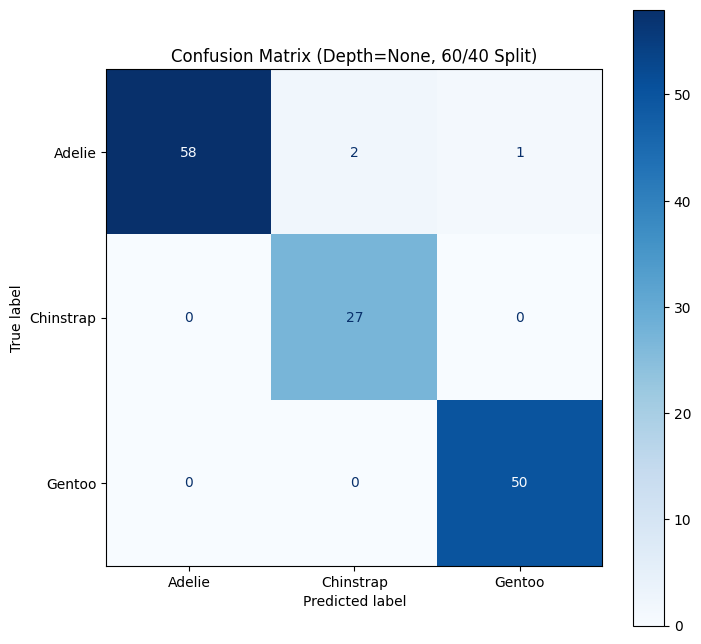

2: Train/Test = 80/20


### Test Size: 0.2

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9000\2512977432.py:3: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y = pd.Series(y.ravel())  # Ensure 1D


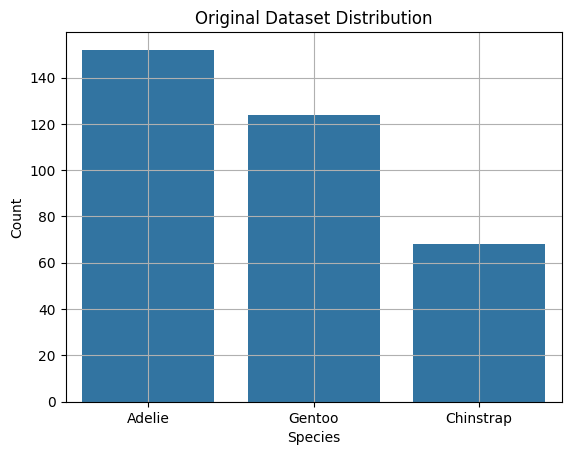

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9000\2512977432.py:3: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y = pd.Series(y.ravel())  # Ensure 1D


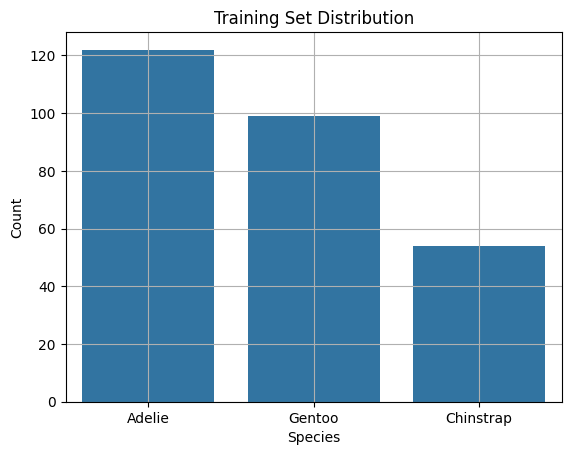

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9000\2512977432.py:3: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y = pd.Series(y.ravel())  # Ensure 1D


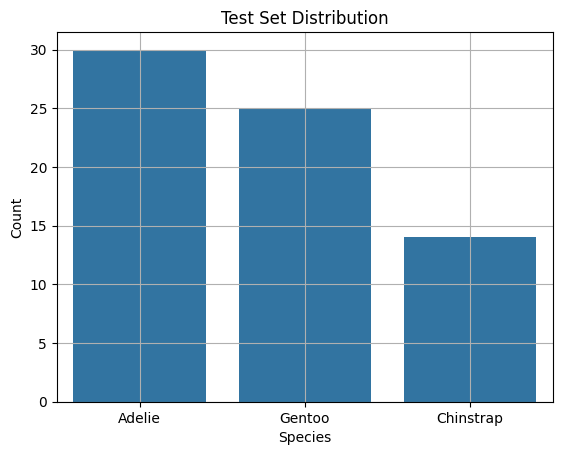

### Decision Tree Visualization

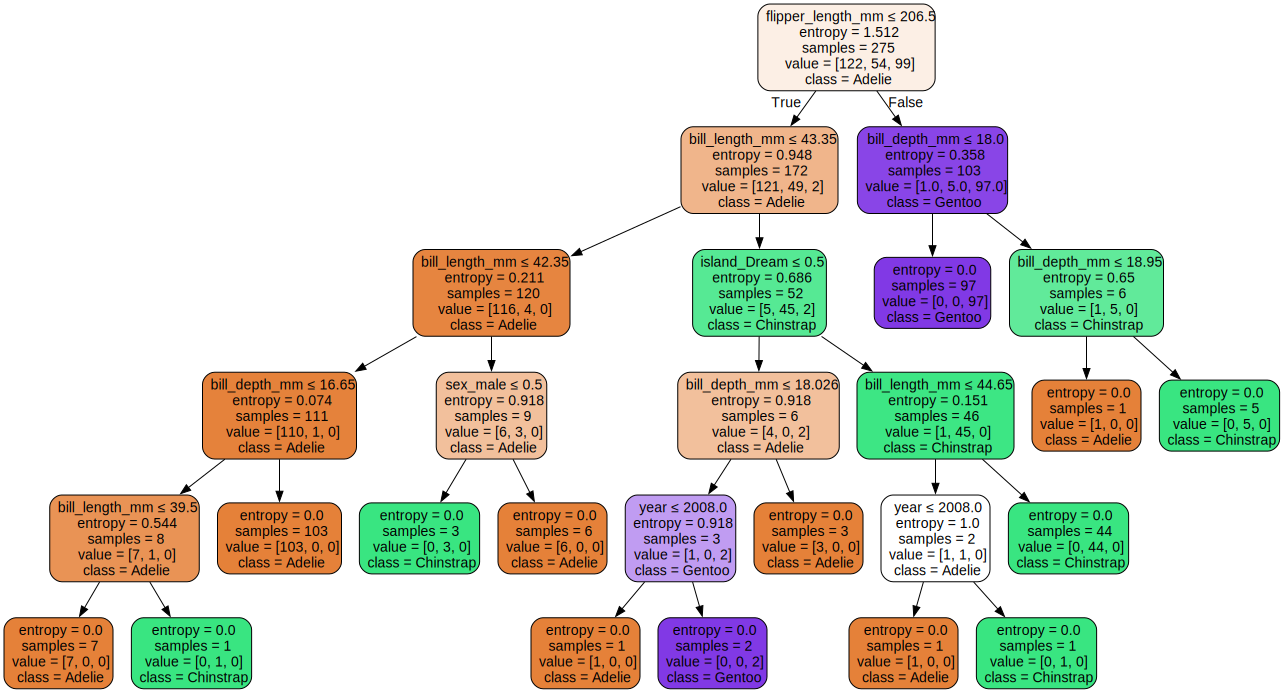

### Classification Report

              precision    recall  f1-score   support

      Adelie       1.00      0.97      0.98        30
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       0.96      1.00      0.98        25

    accuracy                           0.99        69
   macro avg       0.99      0.99      0.99        69
weighted avg       0.99      0.99      0.99        69



### Confusion Matrix

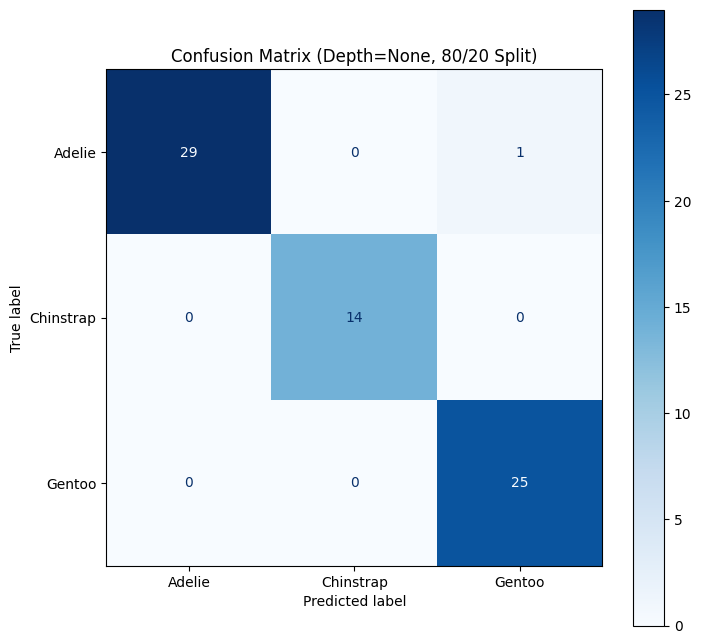

3: Train/Test = 90/10


### Test Size: 0.1

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9000\2512977432.py:3: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y = pd.Series(y.ravel())  # Ensure 1D


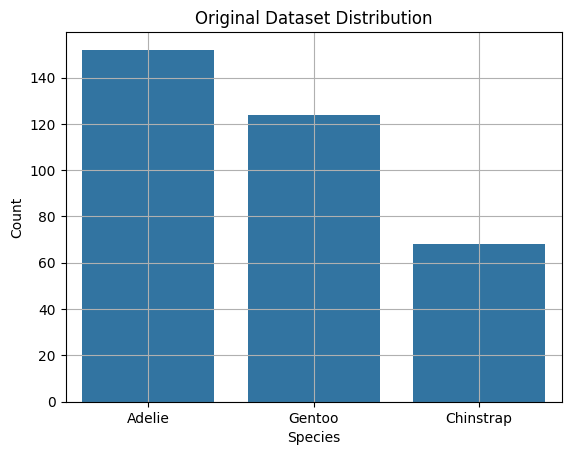

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9000\2512977432.py:3: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y = pd.Series(y.ravel())  # Ensure 1D


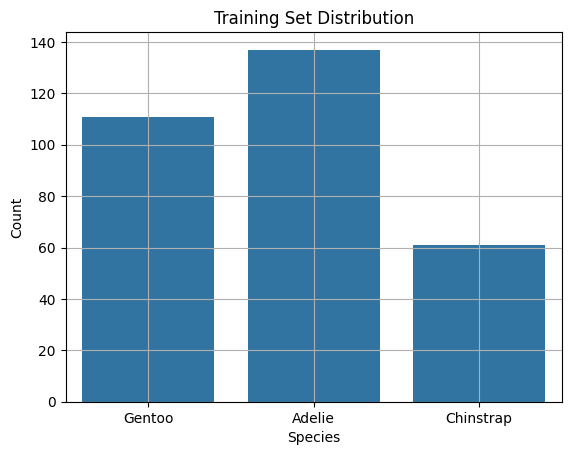

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9000\2512977432.py:3: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y = pd.Series(y.ravel())  # Ensure 1D


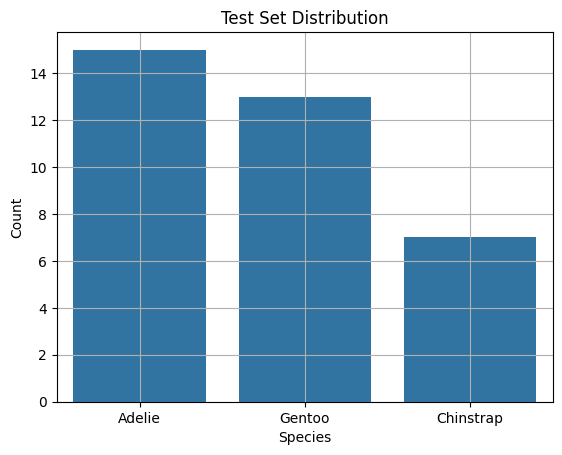

### Decision Tree Visualization

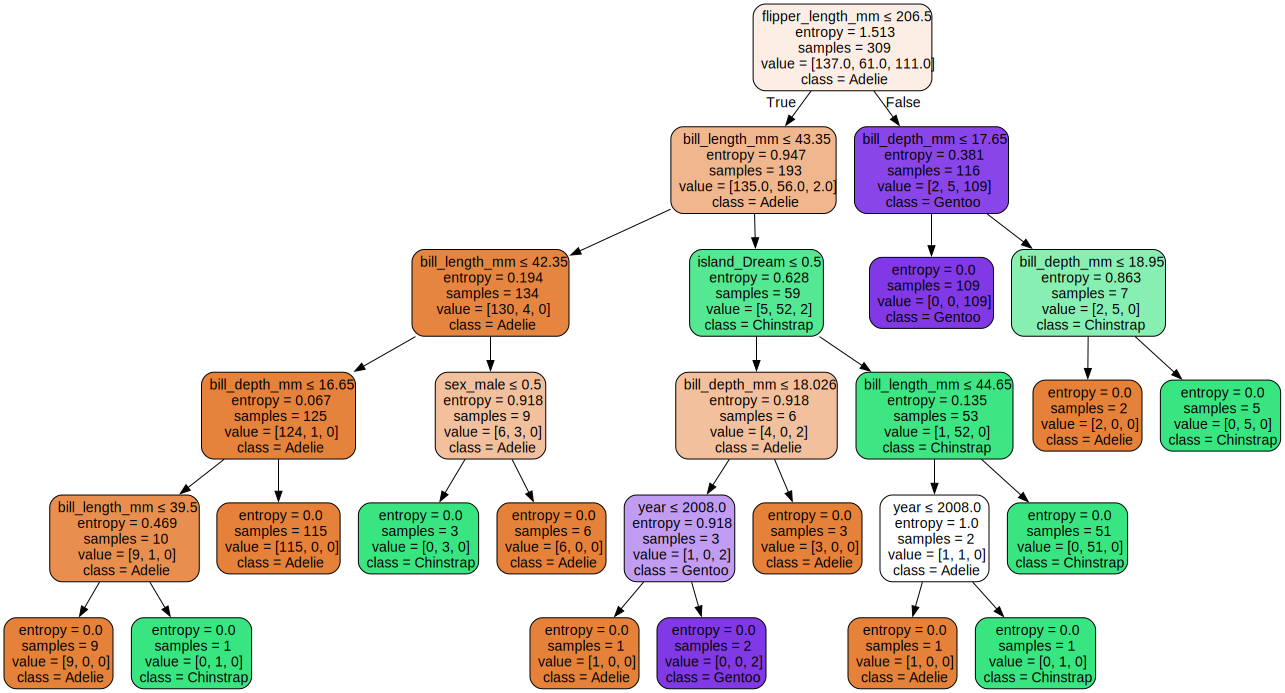

### Classification Report

              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        15
   Chinstrap       1.00      1.00      1.00         7
      Gentoo       1.00      1.00      1.00        13

    accuracy                           1.00        35
   macro avg       1.00      1.00      1.00        35
weighted avg       1.00      1.00      1.00        35



### Confusion Matrix

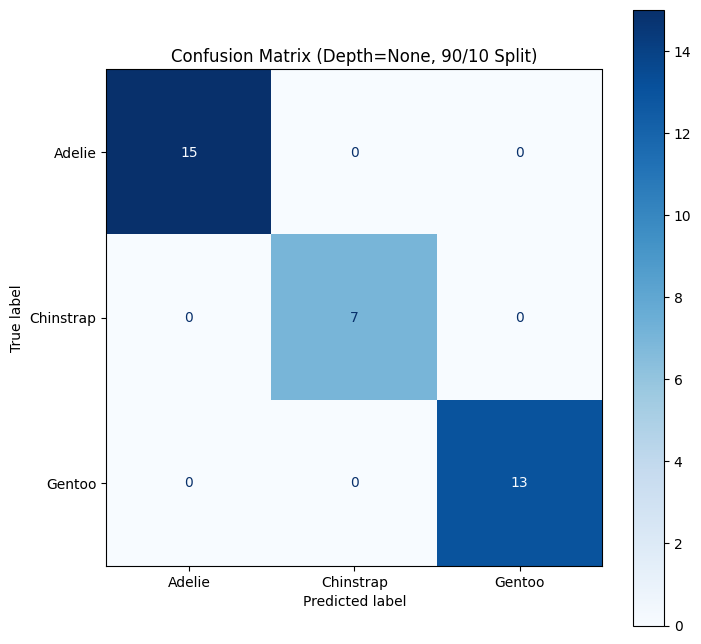

In [11]:
def main(): 
    split_ratios =[0.6, 0.4, 0.2, 0.1]
    X_processed = preprocess_features(X)
    feature_names = X_processed.columns.tolist()
    # Extract feature names from processed dataset for visualization
    target_names = ["Adelie", "Chinstrap", "Gentoo"]
    class_names = [label for label in target_names if label in y.unique()]
    # Filter to get only class names that actually exist in the dataset
    for i in range(0,4):
        print(f"{i}: Train/Test = {100 - int(split_ratios[i] * 100)}/{int(split_ratios[i] * 100)}")
        display(Markdown(f"### Test Size: {split_ratios[i]}"))
        X_train, X_test, y_train, y_test = split_dataset(X_processed, y, split_ratios[i])
        clf = train_decision_tree(X_train, y_train, max_depth=None)
        y_pred = clf.predict(X_test)
        plot_distribution(y, "Original Dataset Distribution")
        plot_distribution(y_train, "Training Set Distribution")
        plot_distribution(y_test, "Test Set Distribution")
        display(Markdown("### Decision Tree Visualization"))
        draw_decision_tree(clf, feature_names, class_names)
        display(Markdown("### Classification Report"))
        print_classification_report(y_test, y_pred,target_names)
        display(Markdown("### Confusion Matrix"))
        plot_confusion_matrix(y_test,y_pred,target_names,labels=class_names,depth=None, test_size=split_ratios[i])
main()

## 12. Depth and Accuracy Analysis

## Depth and Accuracy of Decision Trees - Palmer Penguins

### Analysis using 80/20 train/test split

Training models with different max_depth values...
Training model with max_depth = None...
Accuracy: 0.9855
Training model with max_depth = 2...
Accuracy: 0.9710
Training model with max_depth = 3...
Accuracy: 0.9710
Training model with max_depth = 4...
Accuracy: 1.0000
Training model with max_depth = 5...
Accuracy: 0.9855
Training model with max_depth = 6...
Accuracy: 0.9855
Training model with max_depth = 7...
Accuracy: 0.9855


### Accuracy Results Table

,max_depth,accuracy
0,None,0.9855
1,2,0.9710
2,3,0.9710
3,4,1.0000
4,5,0.9855
5,6,0.9855
6,7,0.9855


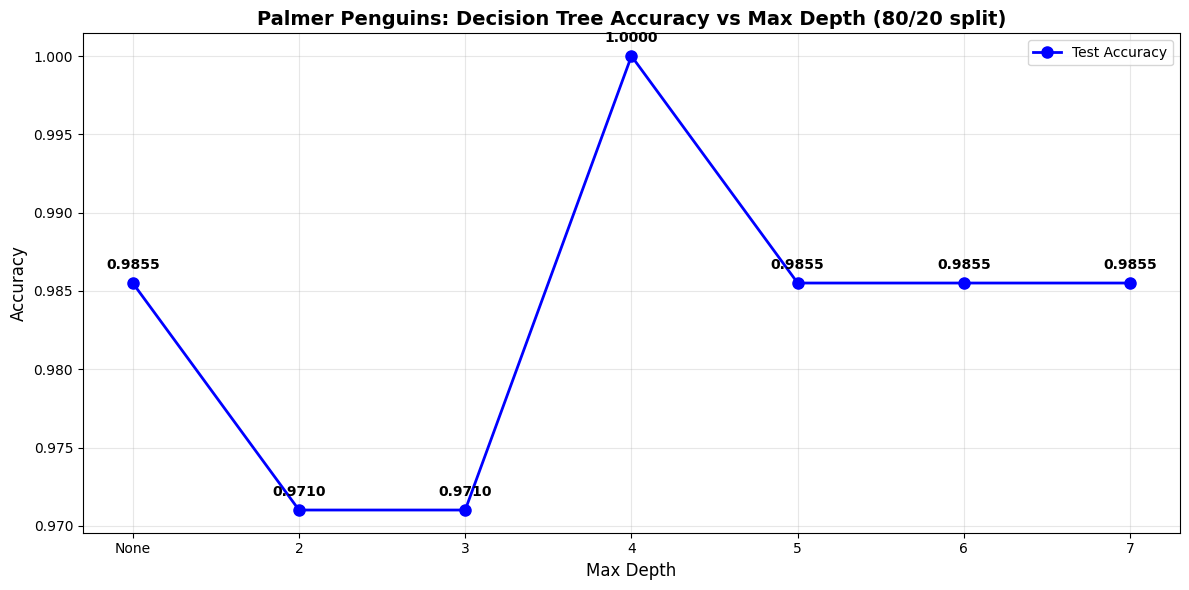

### Decision Tree Visualizations

#### Max Depth = None

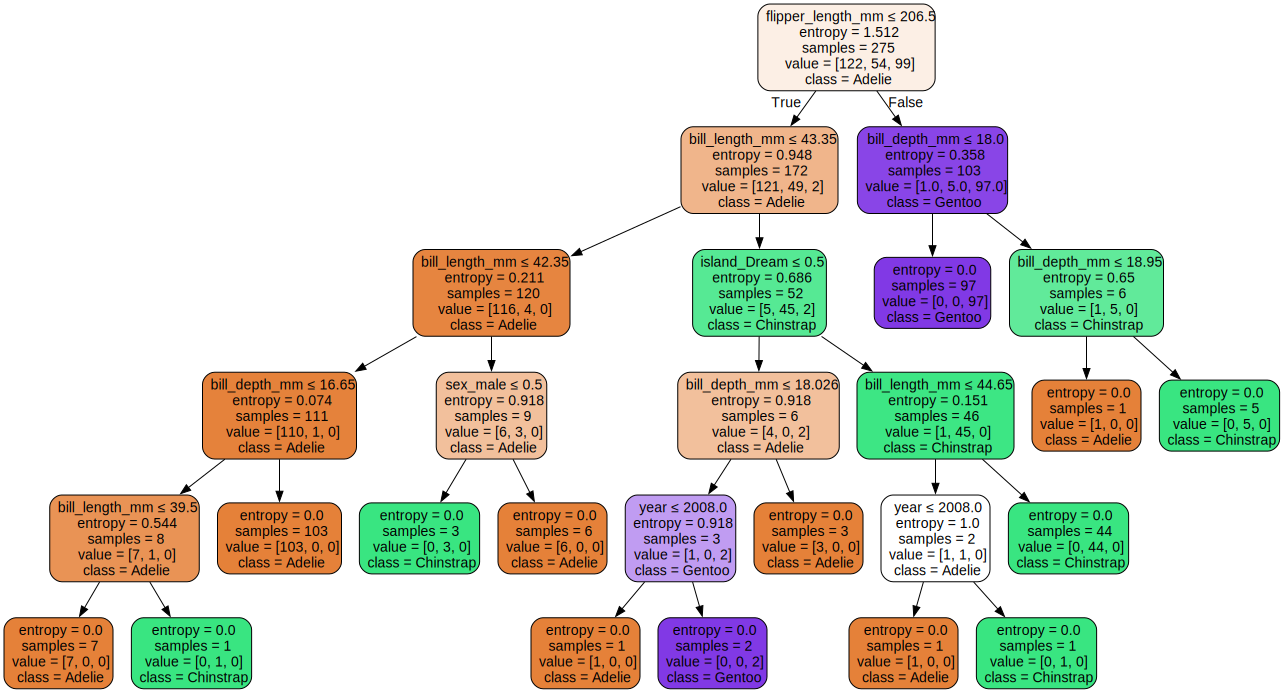

##### Classification Report (Max Depth = None)

              precision    recall  f1-score   support

      Adelie       1.00      0.97      0.98        30
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       0.96      1.00      0.98        25

    accuracy                           0.99        69
   macro avg       0.99      0.99      0.99        69
weighted avg       0.99      0.99      0.99        69



##### Confusion Matrix (Max Depth = None)

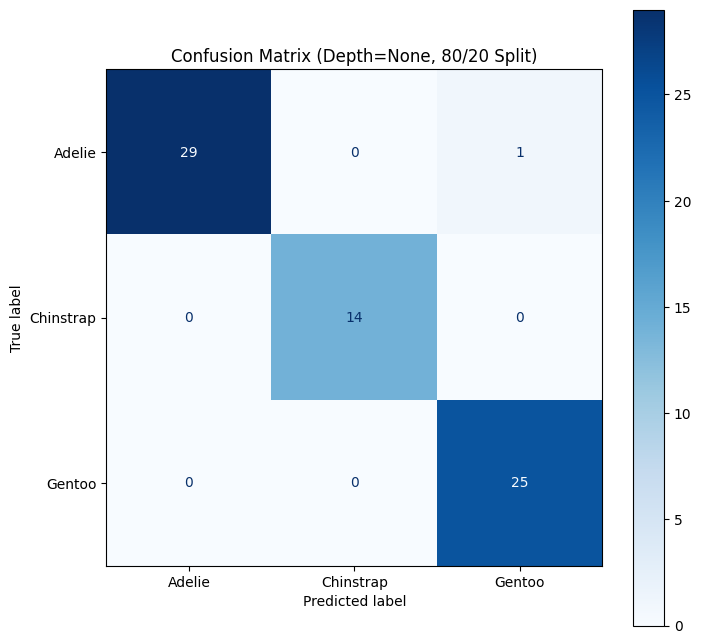

#### Max Depth = 2

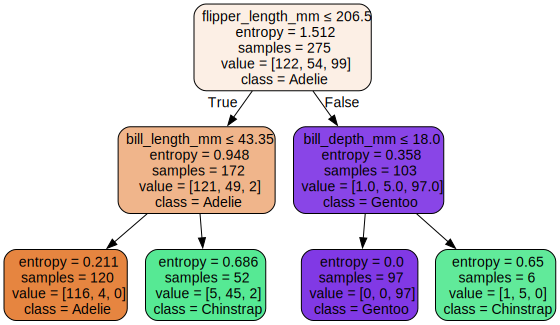

##### Classification Report (Max Depth = 2)

              precision    recall  f1-score   support

      Adelie       0.97      0.97      0.97        30
   Chinstrap       1.00      0.93      0.96        14
      Gentoo       0.96      1.00      0.98        25

    accuracy                           0.97        69
   macro avg       0.98      0.97      0.97        69
weighted avg       0.97      0.97      0.97        69



##### Confusion Matrix (Max Depth = 2)

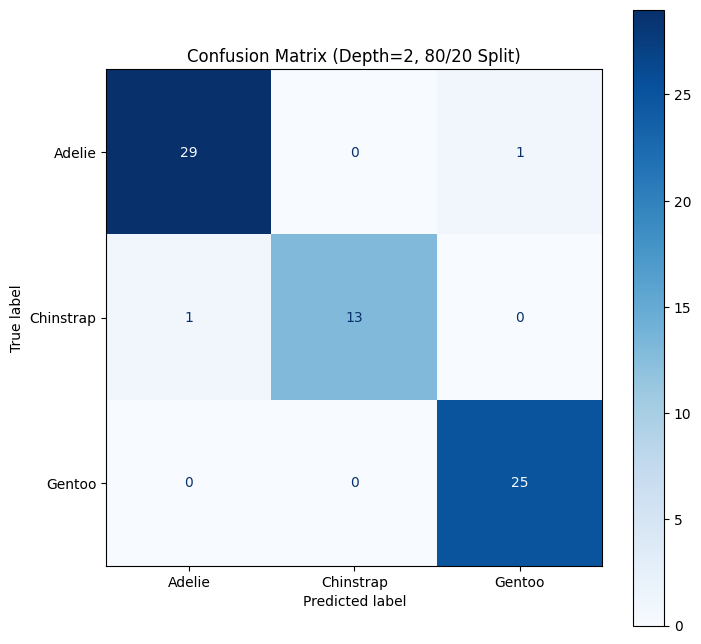

#### Max Depth = 3

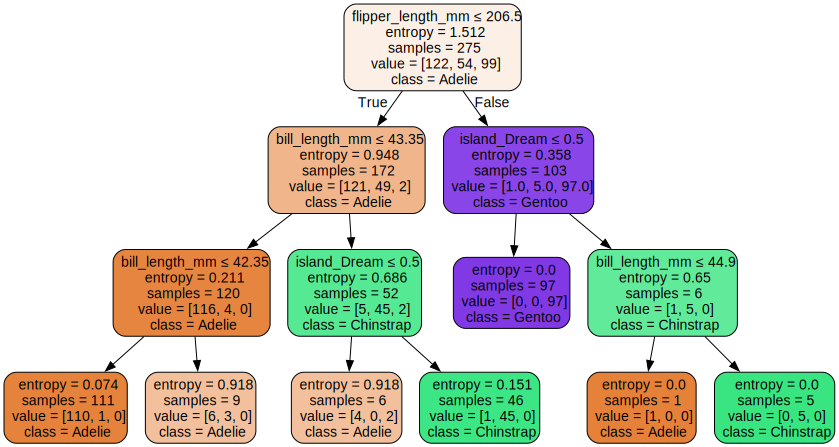

##### Classification Report (Max Depth = 3)

              precision    recall  f1-score   support

      Adelie       0.97      0.97      0.97        30
   Chinstrap       1.00      0.93      0.96        14
      Gentoo       0.96      1.00      0.98        25

    accuracy                           0.97        69
   macro avg       0.98      0.97      0.97        69
weighted avg       0.97      0.97      0.97        69



##### Confusion Matrix (Max Depth = 3)

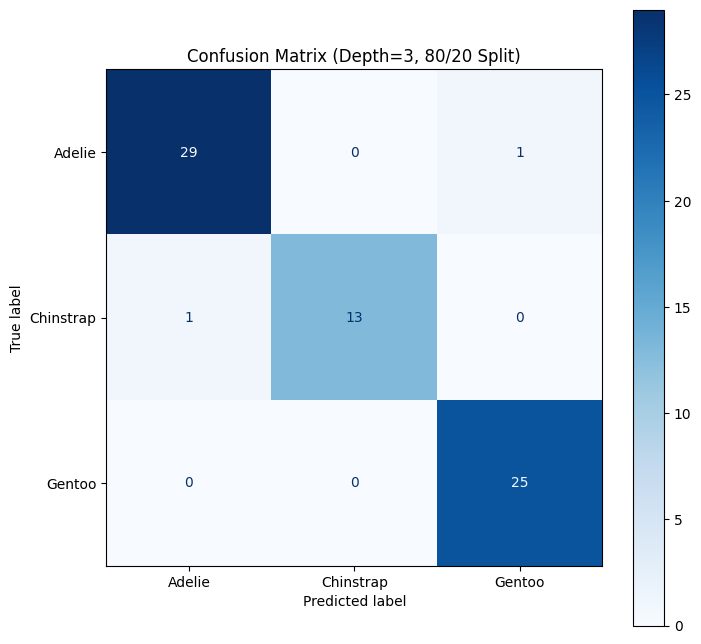

#### Max Depth = 4

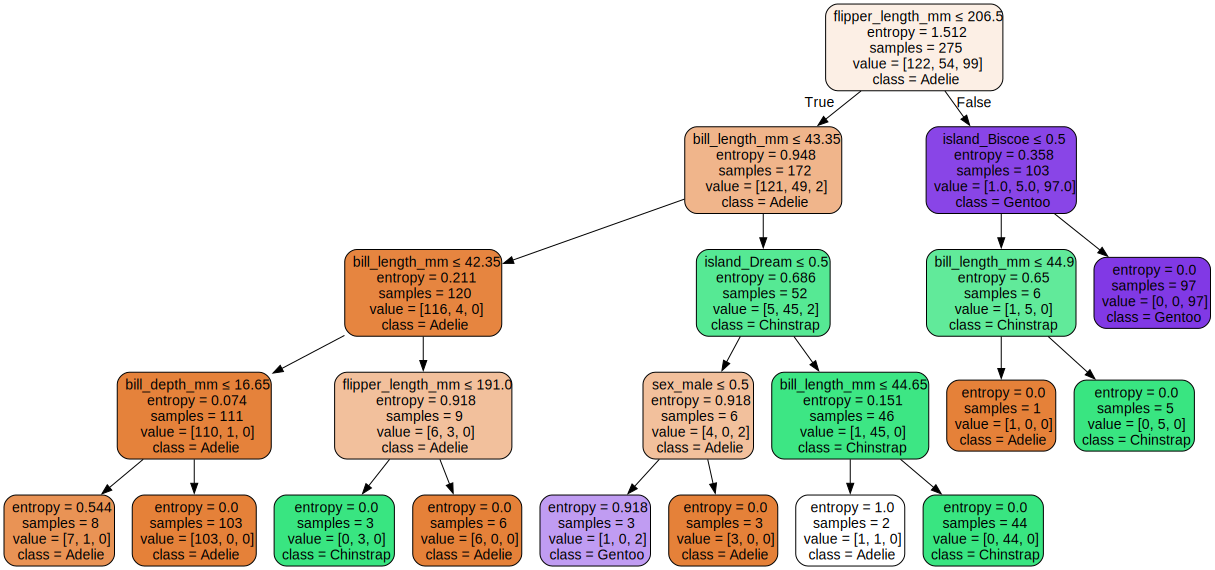

##### Classification Report (Max Depth = 4)

              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        30
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      1.00      1.00        25

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



##### Confusion Matrix (Max Depth = 4)

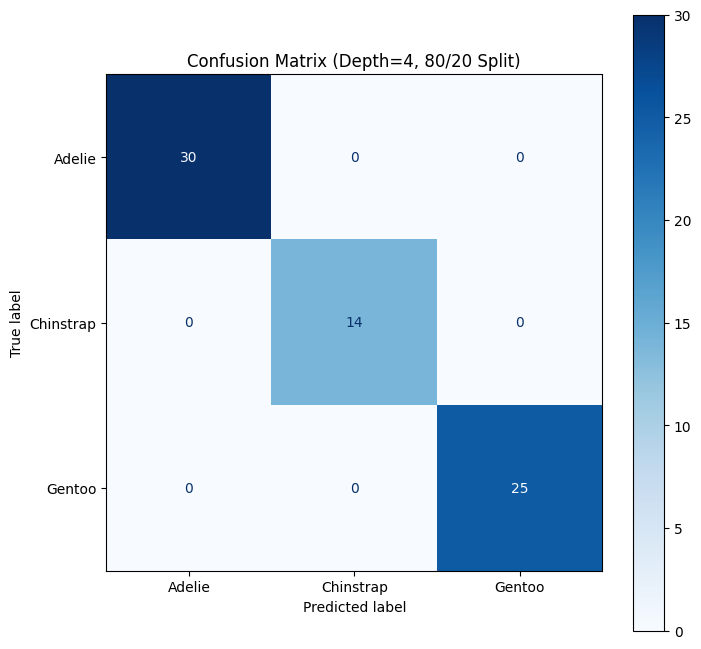

#### Max Depth = 5

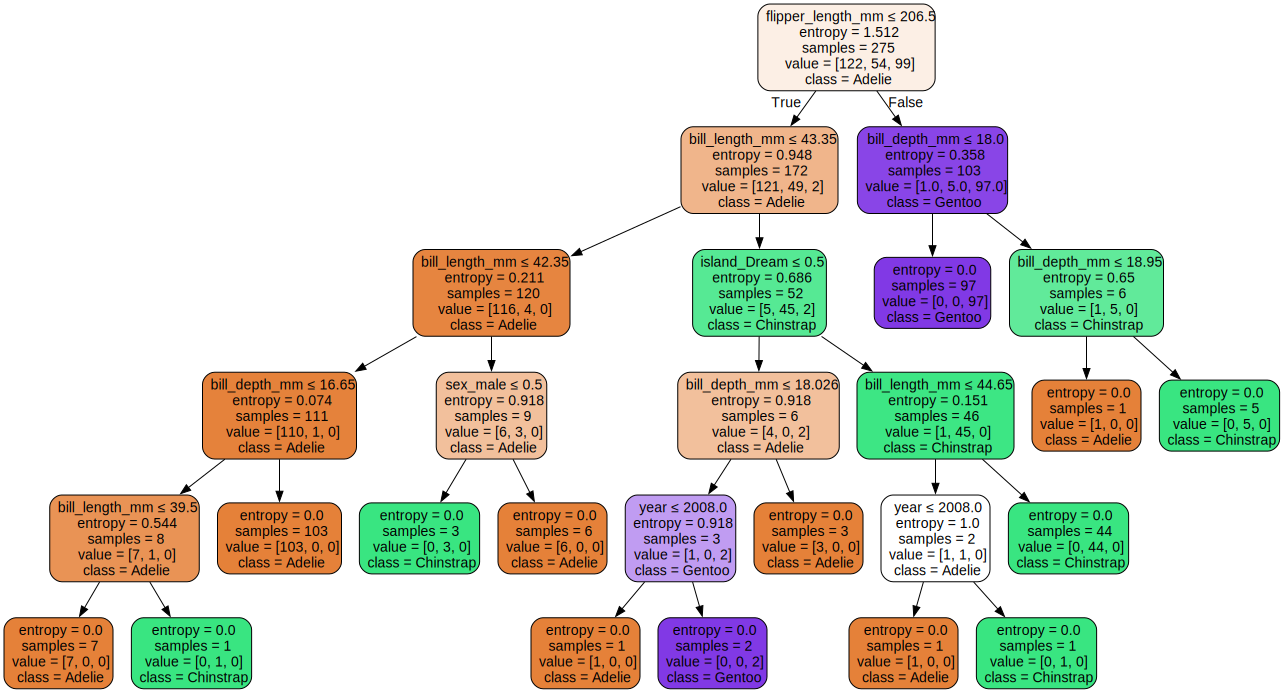

##### Classification Report (Max Depth = 5)

              precision    recall  f1-score   support

      Adelie       1.00      0.97      0.98        30
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       0.96      1.00      0.98        25

    accuracy                           0.99        69
   macro avg       0.99      0.99      0.99        69
weighted avg       0.99      0.99      0.99        69



##### Confusion Matrix (Max Depth = 5)

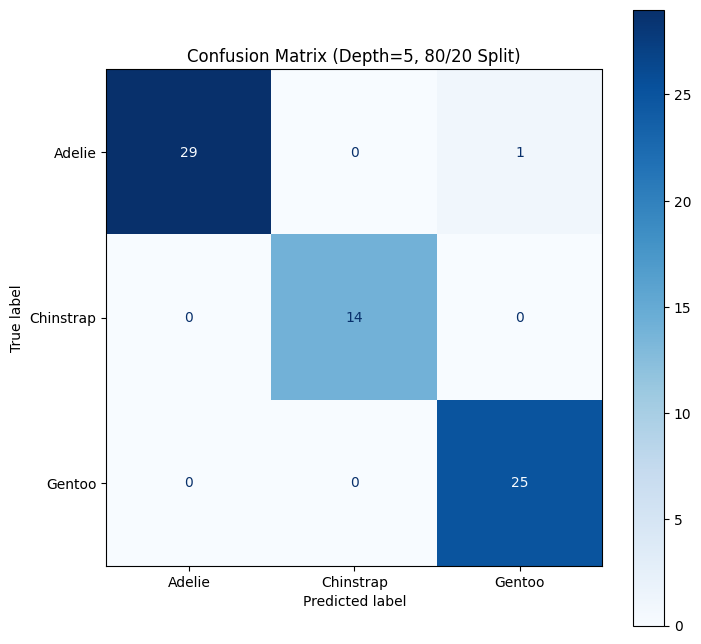

#### Max Depth = 6

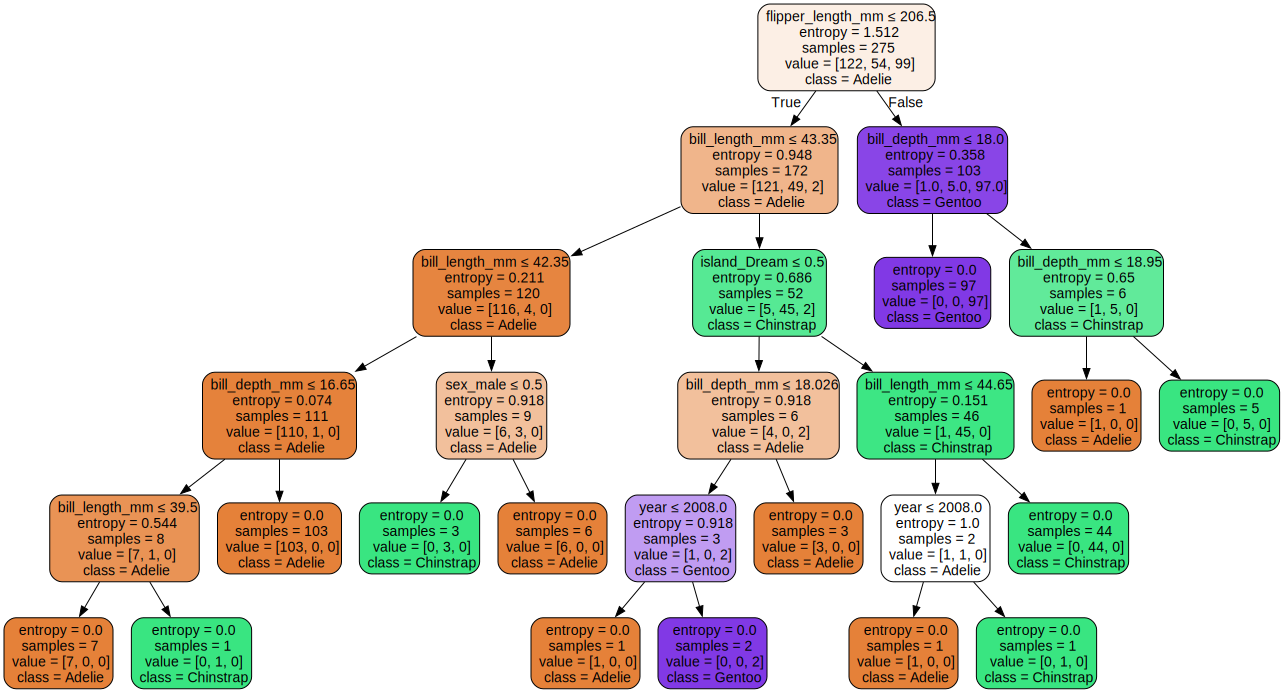

##### Classification Report (Max Depth = 6)

              precision    recall  f1-score   support

      Adelie       1.00      0.97      0.98        30
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       0.96      1.00      0.98        25

    accuracy                           0.99        69
   macro avg       0.99      0.99      0.99        69
weighted avg       0.99      0.99      0.99        69



##### Confusion Matrix (Max Depth = 6)

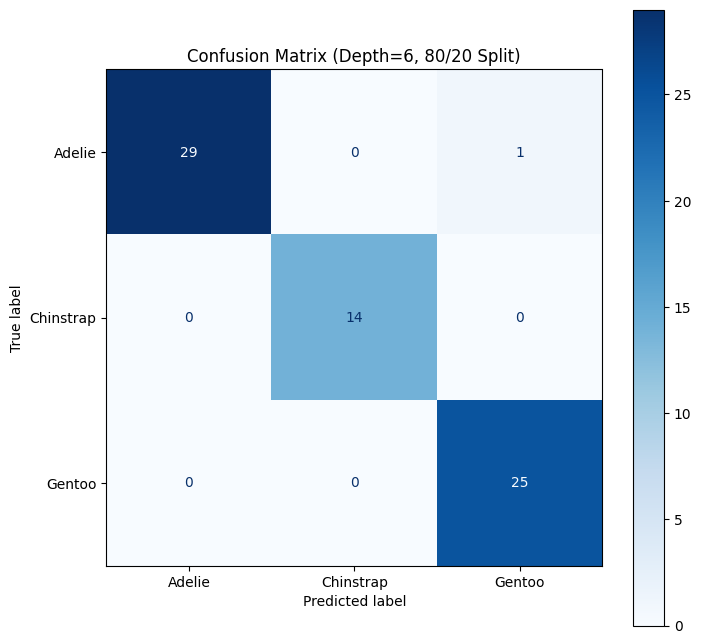

#### Max Depth = 7

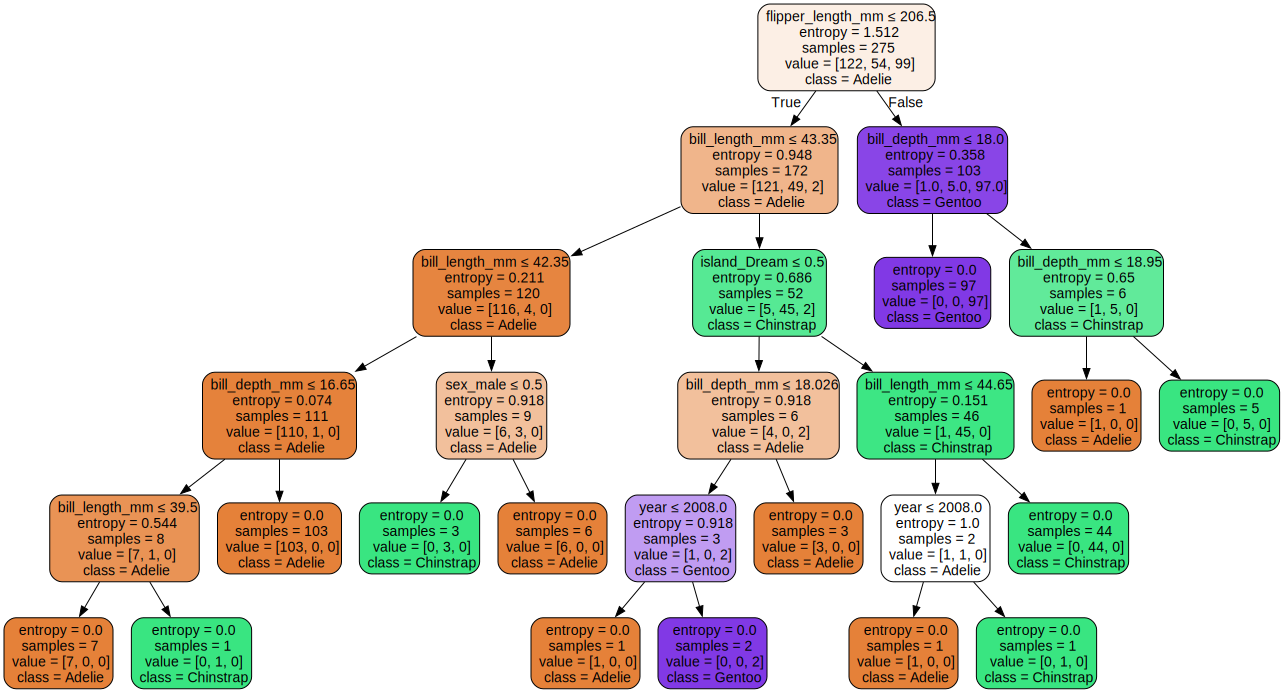

##### Classification Report (Max Depth = 7)

              precision    recall  f1-score   support

      Adelie       1.00      0.97      0.98        30
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       0.96      1.00      0.98        25

    accuracy                           0.99        69
   macro avg       0.99      0.99      0.99        69
weighted avg       0.99      0.99      0.99        69



##### Confusion Matrix (Max Depth = 7)

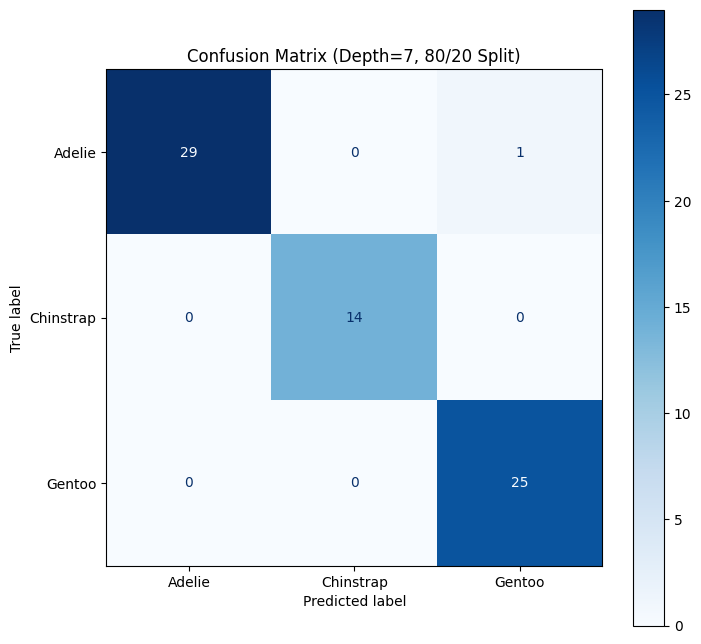

In [17]:
def depth_accuracy_analysis():
    """
    Analyze how decision tree depth affects classification accuracy for Palmer Penguins.
    Uses 80/20 train/test split and tests different max_depth values.
    """
    display(Markdown("## Depth and Accuracy of Decision Trees - Palmer Penguins"))
    display(Markdown("### Analysis using 80/20 train/test split"))
    
    # Preprocess data
    X_processed = preprocess_features(X)
    feature_names = X_processed.columns.tolist()
    target_names = ["Adelie", "Chinstrap", "Gentoo"]
    class_names = [label for label in target_names if label in y.unique()]
    
    # Create 80/20 split (test_size=0.2 means 20% test, 80% train)
    X_train, X_test, y_train, y_test = split_dataset(X_processed, y, test_size=0.2)
    
    # Test different max_depth values
    depth_values = [None, 2, 3, 4, 5, 6, 7]
    results = []
    models = {}
    
    print("Training models with different max_depth values...")
    
    for depth in depth_values:
        print(f"Training model with max_depth = {depth if depth is not None else 'None'}...")
        
        # Train model with specific max_depth
        clf = train_decision_tree(X_train, y_train, max_depth=depth)
        
        # Calculate accuracy on test set
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Store results
        results.append({
            'max_depth': depth if depth is not None else 'None',
            'accuracy': accuracy
        })
        models[depth] = clf
        
        print(f"Accuracy: {accuracy:.4f}")
    
    # Create results table
    results_df = pd.DataFrame(results)
    display(Markdown("### Accuracy Results Table"))
    
    # Format the table for better display
    display_df = results_df.copy()
    display_df['accuracy'] = display_df['accuracy'].apply(lambda x: f"{x:.4f}")
    display(display_df)
    
    # Plot accuracy vs depth using existing function
    depth_labels = [str(d) if d is not None else 'None' for d in depth_values]
    accuracies = [r['accuracy'] for r in results]
    
    # Enhanced plot
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(depth_values)), accuracies, 'bo-', linewidth=2, markersize=8, label='Test Accuracy')
    plt.xticks(range(len(depth_values)), depth_labels)
    plt.title("Palmer Penguins: Decision Tree Accuracy vs Max Depth (80/20 split)", fontsize=14, fontweight='bold')
    plt.xlabel("Max Depth", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add value labels on points
    for i, acc in enumerate(accuracies):
        plt.annotate(f'{acc:.4f}', (i, acc), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Visualize decision trees for each max_depth
    display(Markdown("### Decision Tree Visualizations"))
    
    for depth in depth_values:
        depth_str = str(depth) if depth is not None else 'None'
        display(Markdown(f"#### Max Depth = {depth_str}"))
        
        try:
            # Use existing visualization function
            draw_decision_tree(models[depth], feature_names, class_names)
            
            # Additional evaluation for each depth
            y_pred = models[depth].predict(X_test)
            display(Markdown(f"##### Classification Report (Max Depth = {depth_str})"))
            print_classification_report(y_test, y_pred, target_names)
            
            display(Markdown(f"##### Confusion Matrix (Max Depth = {depth_str})"))
            plot_confusion_matrix(y_test, y_pred, target_names, class_names, depth_str, 0.2)
            
        except Exception as e:
            print(f"Error visualizing tree for depth {depth}: {e}")
            continue
    
    return results_df, models

# Execute the analysis
penguins_results_table, penguins_trained_models = depth_accuracy_analysis()

## 13. Enhanced Results Analysis

In [29]:
def create_detailed_penguins_analysis(results_df, trained_models):
    """Create detailed analysis table with tree complexity metrics."""
    
    display(Markdown("### Detailed Results Analysis - Palmer Penguins"))
    
    # Prepare detailed results
    detailed_results = []
    
    for _, row in results_df.iterrows():
        depth_val = None if row['max_depth'] == 'None' else int(row['max_depth'])
        model = trained_models[depth_val]
        
        # Get tree metrics
        actual_depth = model.tree_.max_depth
        n_leaves = model.tree_.n_leaves
        n_nodes = model.tree_.node_count
        
        detailed_results.append({
            'max_depth': row['max_depth'],
            'accuracy': f"{row['accuracy']:.4f}",
            'actual_depth': actual_depth,
            'n_leaves': n_leaves,
            'n_nodes': n_nodes,
            'performance': 'Best' if row['accuracy'] == results_df['accuracy'].max() 
                         else 'Worst' if row['accuracy'] == results_df['accuracy'].min() 
                         else 'Good' if row['accuracy'] > results_df['accuracy'].mean() 
                         else 'Average'
        })
    
    detailed_df = pd.DataFrame(detailed_results)
    
    # Display table without styling
    display(detailed_df)
    
    return detailed_df

# Create detailed analysis
penguins_detailed_table = create_detailed_penguins_analysis(penguins_results_table, penguins_trained_models)

### Detailed Results Analysis - Palmer Penguins

,max_depth,accuracy,actual_depth,n_leaves,n_nodes,performance
0,None,0.9855,5,14,27,Good
1,2,0.9710,2,4,7,Worst
2,3,0.9710,3,7,13,Worst
3,4,1.0000,4,11,21,Best
4,5,0.9855,5,14,27,Good
5,6,0.9855,5,14,27,Good
6,7,0.9855,5,14,27,Good


## 14. Comprehensive Visualization Charts

### Comprehensive Analysis Charts - Palmer Penguins

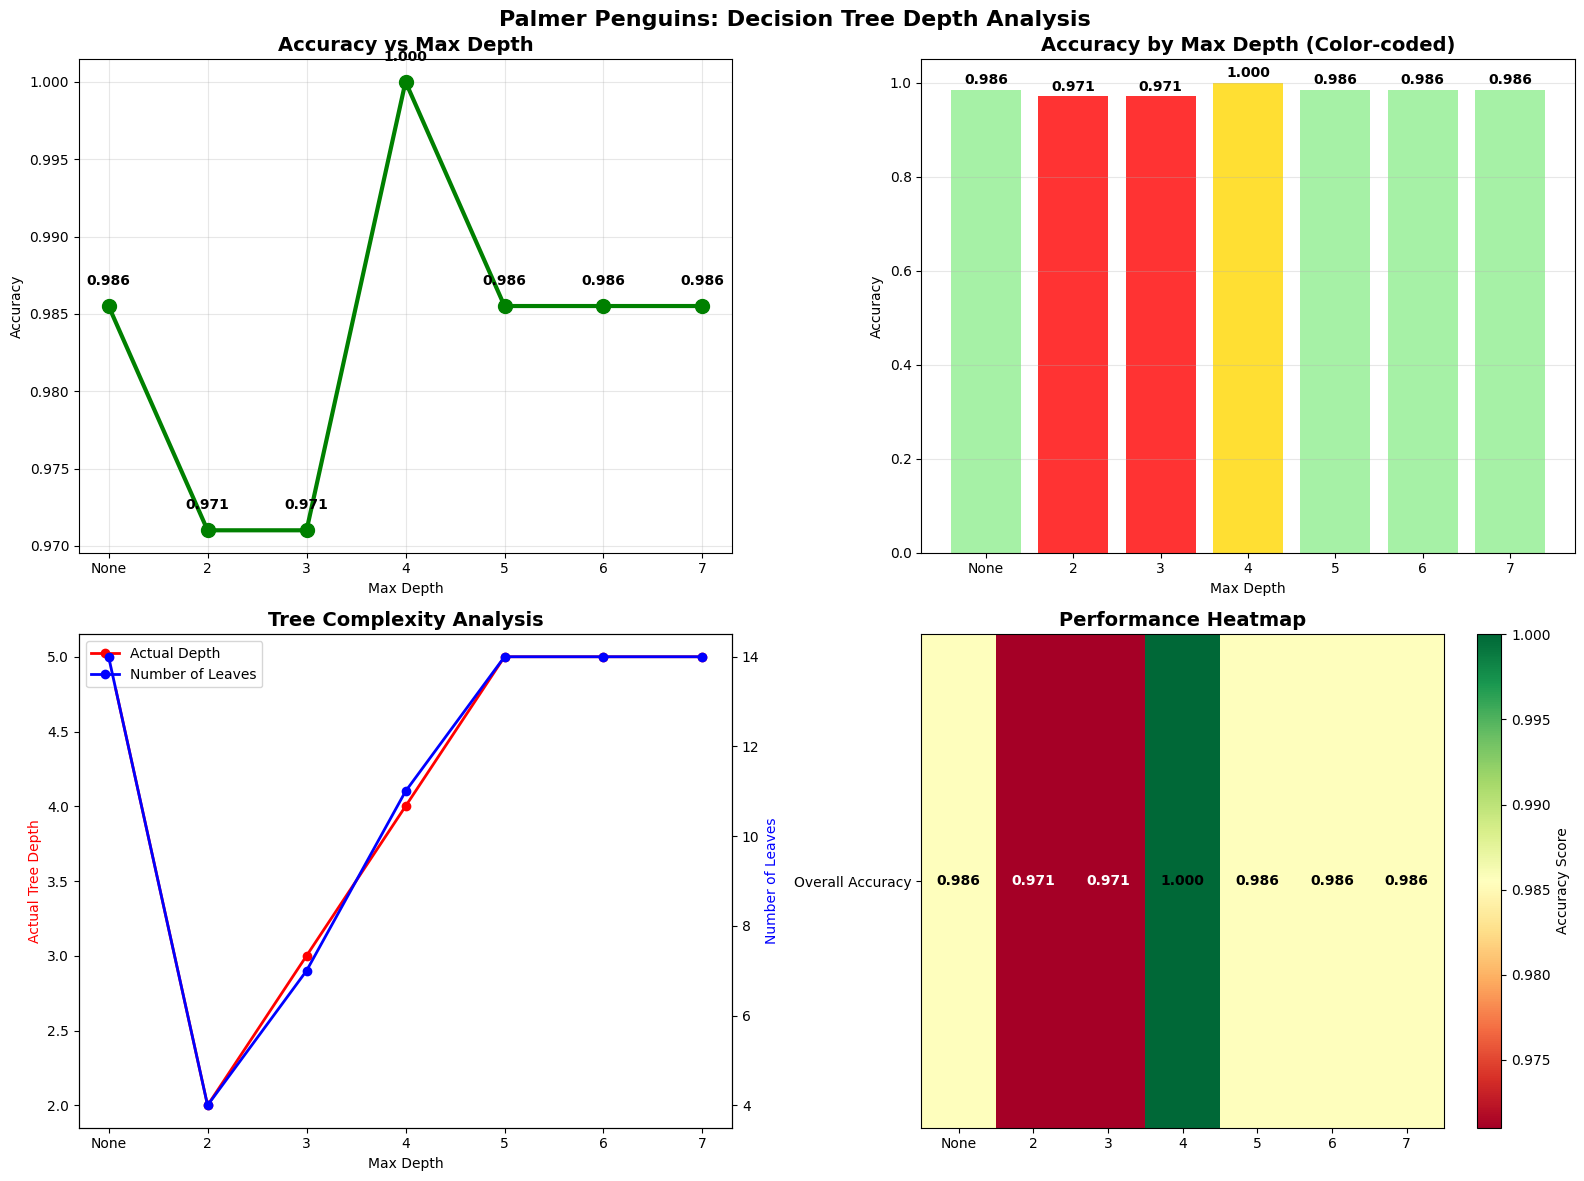

In [14]:
def create_comprehensive_penguins_visualization():
    """Create comprehensive visualization charts for Palmer Penguins depth analysis."""
    
    display(Markdown("### Comprehensive Analysis Charts - Palmer Penguins"))
    
    # Extract data for plotting
    depths = [None, 2, 3, 4, 5, 6, 7]
    depth_labels = ['None', '2', '3', '4', '5', '6', '7']
    
    # Get accuracies from results
    accuracies = [row['accuracy'] for _, row in penguins_results_table.iterrows()]
    
    # Create 2x2 subplot layout
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Palmer Penguins: Decision Tree Depth Analysis', fontsize=16, fontweight='bold')
    
    # 1. Line plot with markers
    ax1.plot(range(len(depths)), accuracies, 'go-', linewidth=3, markersize=10)
    ax1.set_xticks(range(len(depths)))
    ax1.set_xticklabels(depth_labels)
    ax1.set_title('Accuracy vs Max Depth', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Max Depth')
    ax1.set_ylabel('Accuracy')
    ax1.grid(True, alpha=0.3)
    
    # Add annotations
    for i, acc in enumerate(accuracies):
        ax1.annotate(f'{acc:.3f}', (i, acc), textcoords="offset points", 
                    xytext=(0,15), ha='center', fontweight='bold')
    
    # 2. Bar chart with color coding
    colors = ['red' if acc == min(accuracies) else 'gold' if acc == max(accuracies) else 'lightgreen' 
              for acc in accuracies]
    bars = ax2.bar(range(len(depths)), accuracies, color=colors, alpha=0.8)
    ax2.set_xticks(range(len(depths)))
    ax2.set_xticklabels(depth_labels)
    ax2.set_title('Accuracy by Max Depth (Color-coded)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Max Depth')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True, axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, acc) in enumerate(zip(bars, accuracies)):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 3. Tree complexity analysis
    tree_depths = [penguins_trained_models[d].tree_.max_depth for d in depths]
    n_leaves = [penguins_trained_models[d].tree_.n_leaves for d in depths]
    
    ax3_twin = ax3.twinx()
    line1 = ax3.plot(range(len(depths)), tree_depths, 'ro-', label='Actual Depth', linewidth=2)
    line2 = ax3_twin.plot(range(len(depths)), n_leaves, 'bo-', label='Number of Leaves', linewidth=2)
    
    ax3.set_xticks(range(len(depths)))
    ax3.set_xticklabels(depth_labels)
    ax3.set_title('Tree Complexity Analysis', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Max Depth')
    ax3.set_ylabel('Actual Tree Depth', color='red')
    ax3_twin.set_ylabel('Number of Leaves', color='blue')
    
    # Combine legends
    lines1, labels1 = ax3.get_legend_handles_labels()
    lines2, labels2 = ax3_twin.get_legend_handles_labels()
    ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    # 4. Species-wise performance heatmap simulation
    # Create a performance matrix (simulated for visualization)
    performance_data = np.array(accuracies).reshape(1, -1)
    im = ax4.imshow(performance_data, cmap='RdYlGn', aspect='auto')
    ax4.set_xticks(range(len(depths)))
    ax4.set_xticklabels(depth_labels)
    ax4.set_yticks([0])
    ax4.set_yticklabels(['Overall Accuracy'])
    ax4.set_title('Performance Heatmap', fontsize=14, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax4)
    cbar.set_label('Accuracy Score')
    
    # Add text annotations
    for i in range(len(depths)):
        ax4.text(i, 0, f'{accuracies[i]:.3f}', ha='center', va='center', 
                fontweight='bold', color='white' if accuracies[i] < np.mean(accuracies) else 'black')
    
    plt.tight_layout()
    plt.show()

# Create comprehensive visualization
create_comprehensive_penguins_visualization()

## 15. Final Analysis Report

## Final Analysis Report - Palmer Penguins

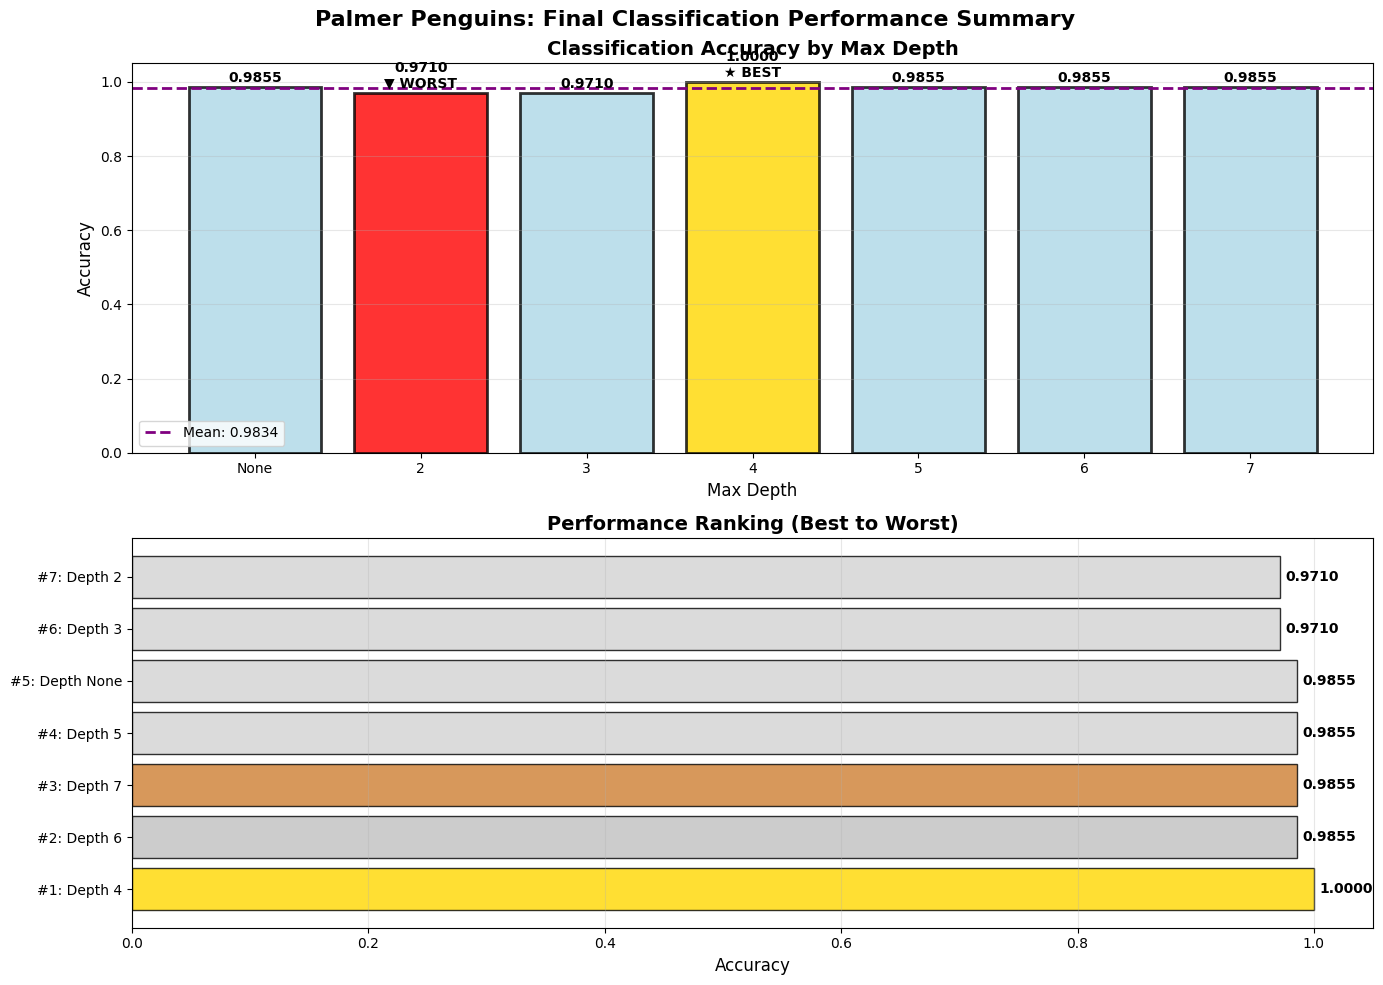

### Feature Importance Analysis

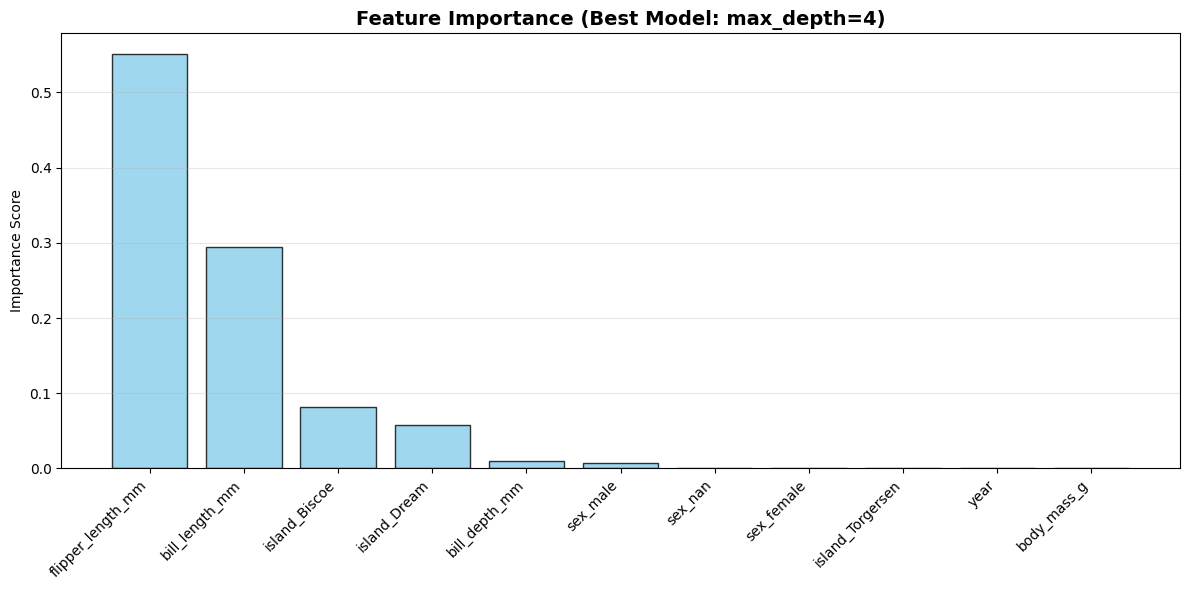

In [18]:
def generate_penguins_final_report():
    """Generate comprehensive final report for Palmer Penguins depth analysis."""
    
    display(Markdown("## Final Analysis Report - Palmer Penguins"))
    
    # Extract key metrics
    accuracies = [row['accuracy'] for _, row in penguins_results_table.iterrows()]
    depths = ['None', '2', '3', '4', '5', '6', '7']
    
    best_idx = np.argmax(accuracies)
    worst_idx = np.argmin(accuracies)
    
    best_depth = depths[best_idx]
    best_accuracy = accuracies[best_idx]
    worst_depth = depths[worst_idx]
    worst_accuracy = accuracies[worst_idx]
    
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    
    
    # Create final summary visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    fig.suptitle('Palmer Penguins: Final Classification Performance Summary', fontsize=16, fontweight='bold')
    
    # Top plot: Accuracy comparison with highlights
    colors = ['red' if i == worst_idx else 'gold' if i == best_idx else 'lightblue' 
              for i in range(len(accuracies))]
    bars = ax1.bar(range(len(depths)), accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    ax1.axhline(y=mean_accuracy, color='purple', linestyle='--', linewidth=2, label=f'Mean: {mean_accuracy:.4f}')
    ax1.set_xticks(range(len(depths)))
    ax1.set_xticklabels(depths)
    ax1.set_title('Classification Accuracy by Max Depth', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Max Depth', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend()
    ax1.grid(True, axis='y', alpha=0.3)
    
    # Add value labels and performance indicators
    for i, (bar, acc) in enumerate(zip(bars, accuracies)):
        label = f'{acc:.4f}'
        if i == best_idx:
            label += '\n★ BEST'
        elif i == worst_idx:
            label += '\n▼ WORST'
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                label, ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # Bottom plot: Performance ranking
    sorted_indices = np.argsort(accuracies)[::-1]
    sorted_depths = [depths[i] for i in sorted_indices]
    sorted_accuracies = [accuracies[i] for i in sorted_indices]
    
    rank_colors = ['gold', 'silver', '#CD7F32'] + ['lightgray'] * (len(depths) - 3)
    bars2 = ax2.barh(range(len(depths)), sorted_accuracies, color=rank_colors, alpha=0.8, edgecolor='black')
    ax2.set_yticks(range(len(depths)))
    ax2.set_yticklabels([f'#{i+1}: Depth {d}' for i, d in enumerate(sorted_depths)])
    ax2.set_title('Performance Ranking (Best to Worst)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Accuracy', fontsize=12)
    ax2.grid(True, axis='x', alpha=0.3)
    
    # Add accuracy labels
    for i, (bar, acc) in enumerate(zip(bars2, sorted_accuracies)):
        ax2.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
                f'{acc:.4f}', ha='left', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Additional insight: Feature importance analysis
    display(Markdown("### Feature Importance Analysis"))
    best_model = penguins_trained_models[None if best_depth == 'None' else int(best_depth)]
    
    # Get feature names
    X_processed = preprocess_features(X)
    feature_names = X_processed.columns.tolist()
    
    # Plot feature importance
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 6))
    plt.title(f'Feature Importance (Best Model: max_depth={best_depth})', fontsize=14, fontweight='bold')
    plt.bar(range(len(importances)), importances[indices], alpha=0.8, color='skyblue', edgecolor='black')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.ylabel('Importance Score')
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Generate final report
generate_penguins_final_report()

## 16. Summary Table for Quick Reference

In [30]:
def create_summary_table():
    """Create a comprehensive summary table for quick reference."""
    
    display(Markdown("### Complete Palmer Penguins Analysis Summary"))
    
    # Combine all metrics
    summary_data = []
    depths = [None, 2, 3, 4, 5, 6, 7]
    
    for i, depth in enumerate(depths):
        model = penguins_trained_models[depth]
        accuracy = [row['accuracy'] for _, row in penguins_results_table.iterrows()][i]
        
        summary_data.append({
            'Max Depth': str(depth) if depth is not None else 'None',
            'Accuracy': f"{accuracy:.4f}",
            'Actual Depth': model.tree_.max_depth,
            'Leaves': model.tree_.n_leaves,
            'Nodes': model.tree_.node_count,
            'Rank': sorted(range(len(depths)), key=lambda x: [row['accuracy'] for _, row in penguins_results_table.iterrows()][x], reverse=True).index(i) + 1
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Display table without styling
    display(summary_df)
    
    return summary_df

# Create summary table
penguins_summary = create_summary_table()

# Print final recommendation
accuracies = [row['accuracy'] for _, row in penguins_results_table.iterrows()]
best_idx = np.argmax(accuracies)
depths = ['None', '2', '3', '4', '5', '6', '7']
best_depth = depths[best_idx]
best_accuracy = accuracies[best_idx]

print("FINAL RECOMMENDATION FOR PALMER PENGUINS CLASSIFICATION")
print(f"Optimal max_depth: {best_depth}")
print(f"Expected accuracy: {best_accuracy:.4f}")
print(f"Model complexity: {'Low' if best_depth in ['2', '3'] else 'Medium' if best_depth in ['4', '5'] else 'High'}")
print(f"Interpretability: {'High' if best_depth in ['2', '3'] else 'Medium' if best_depth in ['4', '5'] else 'Lower'}")

### Complete Palmer Penguins Analysis Summary

,Max Depth,Accuracy,Actual Depth,Leaves,Nodes,Rank
0,None,0.9855,5,14,27,2
1,2,0.9710,2,4,7,6
2,3,0.9710,3,7,13,7
3,4,1.0000,4,11,21,1
4,5,0.9855,5,14,27,3
5,6,0.9855,5,14,27,4
6,7,0.9855,5,14,27,5


FINAL RECOMMENDATION FOR PALMER PENGUINS CLASSIFICATION
Optimal max_depth: 4
Expected accuracy: 1.0000
Model complexity: Medium
Interpretability: Medium
